# Amazon deforestation causes strong regional warming

Edward W. Butt1*, Jessica C. A. Baker1, Francisco G. Silva Bezerra2, Celso von Randow2, Ana P. D. Aguiar2, 3 and Dominick V. Spracklen1

1. School of Earth and Environment, University of Leeds, Leeds, UK
2. National Institute for Space Research (INPE), São José dos Campos, Brazil.
3. Stockholm Resilience Centre, Stockholm, Sweden.

*Correspondence to Edward W. Butt: e.butt@leeds.ac.uk


### Code to run the XGBoost model

* Data used to run this code can be downloaded from: https://doi.org/10.5518/1325
* README.txt found at the same address describes the data

To run this code, you will need the correct packages installed on your system. You may want to create the following conda environment:

conda create -n runmodel -c conda-forge -c python jupyterlab numpy pandas matplotlib seaborn jupyter scikit-learn xgboost

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.base import clone

import warnings
warnings.filterwarnings('ignore')

### Open dataset

In [2]:
df = pd.read_csv('Dataset_butt_etal.csv')

In [3]:
df.head()

lat     lon  Latitude_rescale  Elevation_rescale  \
0   2.825 -68.335          0.766579           0.242639   
1  -3.995 -48.025          0.542679           0.253007   
2  -7.315 -55.255          0.433684           0.528292   
3  -8.955 -54.245          0.379842           0.758576   
4 -16.405 -60.475          0.135259           0.720493   

   Distance_coast_rescale  local_0-2km_start  regional_2-5km_start  \
0                0.508327              0.985                  0.99   
1                0.159400              0.860                  0.79   
2                0.527255              0.770                  0.79   
3                0.582676              0.980                  0.99   
4                0.706369              0.925                  0.91   

   regional_5-10km_start  regional_10-25km_start  regional_25-50km_start  ...  \
0                   0.99                    0.99                    0.97  ...   
1                   0.73                    0.75                    0.75  ...   
2                   0.77                    0.87                    0.89  ...   
3                   0.99                    0.99                    0.96  ...   
4                   0.92                    0.89                    0.70  ...   

   regional_5-10km_end  regional_10-25km_end  regional_25-50km_end  \
0                 0.99                  0.99                  0.97   
1                 0.33                  0.44                  0.50   
2                 0.39                  0.51                  0.64   
3                 0.99                  0.98                  0.92   
4                 0.80                  0.67                  0.56   

   regional_50-100km_end   Delta_T  regional_2-10km_start  \
0                   0.95 -0.727778                  0.990   
1                   0.52  0.532636                  0.760   
2                   0.76  1.826663                  0.780   
3                   0.83  0.088342                  0.990   
4                   0.60  0.943321                  0.915   

   regional_2-10km_end  regional_10-100km_start  regional_10-100km_end  \
0                0.990                 0.973333               0.970000   
1                0.450                 0.740000               0.486667   
2                0.460                 0.906667               0.636667   
3                0.990                 0.950000               0.910000   
4                0.835                 0.760000               0.610000   

   train_test_split  
0             train  
1             train  
2             train  
3             train  
4             train  

[5 rows x 23 columns]

Print data columns

In [4]:
df.columns

Index(['lat', 'lon', 'Latitude_rescale', 'Elevation_rescale',
       'Distance_coast_rescale', 'local_0-2km_start', 'regional_2-5km_start',
       'regional_5-10km_start', 'regional_10-25km_start',
       'regional_25-50km_start', 'regional_50-100km_start', 'local_0-2km_end',
       'regional_2-5km_end', 'regional_5-10km_end', 'regional_10-25km_end',
       'regional_25-50km_end', 'regional_50-100km_end', 'Delta_T',
       'regional_2-10km_start', 'regional_2-10km_end',
       'regional_10-100km_start', 'regional_10-100km_end', 'train_test_split'],
      dtype='object')

### Create XGBoost model

Load model parameters that we will be using, which have been selected as a result of both a cv search algorithm and trial and error. 

In [5]:
best_params =  np.load('best_params.npy',allow_pickle='TRUE').item()

model = xgb.XGBRegressor(colsample_bytree = best_params['colsample_bytree'],
                         gamma = best_params['gamma'],
                         reg_lambda = best_params['lambda'],    
                         learning_rate = best_params['learning_rate'],
                         max_depth = best_params['max_depth'],
                         min_child_weight = best_params['min_child_weight'],
                         n_estimators = best_params['n_estimators'],
                         objective = best_params['objective'],
                         subsample = best_params['subsample'],
                         random_state = 42
                        )

Model parameters that we will be using

In [6]:
best_params

{'colsample_bytree': 0.7,
 'gamma': 0,
 'lambda': 0.5,
 'learning_rate': 0.05,
 'max_depth': 18,
 'min_child_weight': 4,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 1}

### Create model class

In [7]:
class Model():
    
    def __init__(self, model, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model.fit(X_train.values, y_train.values)
            
    def predict(self):
        pred_train = self.model.predict(self.X_train.values)
        pred_test = self.model.predict(self.X_test.values)
        pred_dict = {'train':pred_train,
                     'test':pred_test
                    }
        return pred_dict

    def predict_metric_test(self):
        pred_dict = self.predict()
        X_dict = {'train': self.X_train,
                 'test': self.X_test
                 }
        y_dict = {'train': self.y_train,
                 'test': self.y_test
                 }   
        pred_list_labels = ['train','test'] 
        for p in pred_list_labels:
            mae = abs(pred_dict[p] - y_dict[p])
            rmse = round(math.sqrt( ( (mae) **2).mean() ), 6)
            r2 = round(r2_score(pred_dict[p],y_dict[p]), 6)
            metrics = pd.DataFrame({'MAE':[np.mean(mae)],
                        'RMSE':[rmse],
                        'R2':[r2]
                            })   
            # Save predictions and metric dataframes 
            X_copy = X_dict[p].copy()
            X_copy['y_obs'] = y_dict[p].values
            X_copy['y_preds'] = np.array(pred_dict[p])
            X_copy.to_csv('DataFrame_' + p + '_obs_preds_baseline.csv', 
                           index=False)
            metrics.to_csv('DataFrame_obs_preds_' + p + '_baseline_metrics.csv',
                       index=False)
            print(''+ p +' metrics are:')
            print(metrics)
            
            # Save model
            self.model.save_model('baseline_0001.model')

    def plot_test_121(self):
        prediction = self.predict()
        prediction = prediction['test']
        mae = abs(prediction - self.y_test)
        met = pd.DataFrame({'MAE':[np.mean(mae)],
                        'RMSE':[ round(math.sqrt( ( (mae) **2).mean() ), 6) ],
                        'R2':[ round(r2_score(prediction,self.y_test), 6) ]
                            })
        # Plot
        fig, ax = plt.subplots()
        sns.scatterplot(x=np.array(prediction), y=np.array(self.y_test), s=80)
        ax.set_ylabel('Observed \u0394T (K)', size=15)
        ax.set_xlabel('Predicted \u0394T (K)', size=15)        
        plt.xlim(-8., 11.)
        plt.ylim(-8., 11.)
        plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha=0.2)
        style = dict(size=15, color='black')
        ax.text(-7.,10., 'MAE: '+ str(round(met['MAE'][0],3)), **style)
        ax.text(-7.,9, 'RMSE: '+ str(round(met['RMSE'][0],3)), **style)
        ax.text(-7.,8., 'R$^{2}$: '+ str(round(met['R2'][0],3)), **style)
        
        plt.savefig('Plot_121_test_prediction_observation_data.pdf')
        return plt.show()
   

### Prepare model features

Calculate forest fraction change or loss between start and end features for local and regional distance features

In [8]:
df['local_0-2km_change'] = (df['local_0-2km_start'] - df['local_0-2km_end'])
df['regional_2-5km_change'] = (df['regional_2-5km_start'] - df['regional_2-5km_end'])
df['regional_5-10km_change'] = (df['regional_5-10km_start'] - df['regional_5-10km_end'])
df['regional_10-25km_change'] = (df['regional_10-25km_start'] - df['regional_10-25km_end'])
df['regional_25-50km_change'] = (df['regional_25-50km_start'] - df['regional_25-50km_end'])
df['regional_50-100km_change'] = (df['regional_50-100km_start'] - df['regional_50-100km_end'])

Model features

In [9]:
features = [
            'Latitude_rescale','Elevation_rescale','Distance_coast_rescale',
            'local_0-2km_change',
            'regional_2-5km_change',
            'regional_5-10km_change', 
            'regional_10-25km_change',
            'regional_25-50km_change',
            'regional_50-100km_change' 
            ]

Target feature: Surface temperature change calculated by subtracting the average surface temperature of the driest month for two periods at the end (2018 to 2020) and start (2001 to 2003) of the study period.

In [10]:
target = 'Delta_T'

Prepare train and test datasets

In [11]:
# Get X,Y datasets
X = df[features]
y = df[target]
    
print('Model features are:')
print(X.columns)
    
print('Split into train and test datasets')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
    
print('Length of train test sets are:')
print(len(X_train))
print(len(X_test))

print('Target range for the train and test sets are:')
print(np.min(y_train), np.max(y_train))
print(np.min(y_test), np.max(y_test))

Model features are:
Index(['Latitude_rescale', 'Elevation_rescale', 'Distance_coast_rescale',
       'local_0-2km_change', 'regional_2-5km_change', 'regional_5-10km_change',
       'regional_10-25km_change', 'regional_25-50km_change',
       'regional_50-100km_change'],
      dtype='object')
Split into train and test datasets
Length of train test sets are:
3507049
184582
Target range for the train and test sets are:
-9.529809511872372 11.616497620957096
-7.522275384748882 10.641018961318537


### Initiate model class

In [12]:
mc = Model(model, X_train, y_train, X_test, y_test)

Calculate model evaluation metrics

In [13]:
print('Calculating model evaluation metrics')
mc.predict_metric_test()

Calculating model evaluation metrics
train metrics are:
        MAE      RMSE        R2
0  0.242419  0.340063  0.901108
test metrics are:
        MAE      RMSE        R2
0  0.311401  0.453522  0.811948


Plot 121 for prediction on test set and observed data

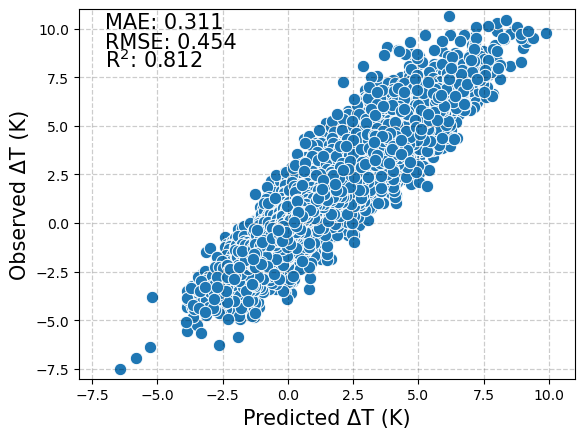

In [14]:
mc.plot_test_121() 